In [1]:
import matplotlib.pyplot as plt
import math
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn import manifold, datasets
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA
import pandas as pd
from scipy.spatial import distance
from sklearn.neighbors import kneighbors_graph
import scipy.linalg as la
from scipy.stats import pearsonr

# face plotting function
import matplotlib.pyplot as plt
colors = {'laserHI': 'darkgreen', 'laserLO': 'lightgreen', 'laserCTRL': 'gray','shock':'red', 'shockCTRL': 'orange', 'baseline':'dodgerblue',
         'squeak' : 'purple', 'squeakCTRL': 'pink'}
def plot(d,n,c,batch):
    plt.scatter(x=d.loc[n, ['Ear1.X', 'Ear2.X', 'Ear3.X', \
                    'Ear4.X', 'Ear5.X', 'Eye1.X', 'Eye2.X', 'Eye3.X',\
                    'Eye4.X', 'SnoutMid.X', 'NoseTip.X', 'Mouth.X']], y=-d.loc[n, ['Ear1.Y', 'Ear2.Y', 'Ear3.Y', \
                    'Ear4.Y', 'Ear5.Y', 'Eye1.Y', 'Eye2.Y', 'Eye3.Y',\
                    'Eye4.Y', 'SnoutMid.Y', 'NoseTip.Y', 'Mouth.Y']], color=c)
    plt.plot(d.loc[n, ['Ear1.X', 'Ear2.X', 'Ear3.X', \
                    'Ear4.X', 'Ear5.X','Ear1.X']],-d.loc[n, ['Ear1.Y', 'Ear2.Y', 'Ear3.Y', \
                    'Ear4.Y', 'Ear5.Y','Ear1.Y']], color=c)
    plt.plot(d.loc[n, ['Eye1.X', 'Eye2.X', 'Eye3.X',\
                    'Eye4.X','Eye1.X']],-d.loc[n, ['Eye1.Y', 'Eye2.Y', 'Eye3.Y',\
                    'Eye4.Y','Eye1.Y']], color=c)
    plt.plot(d.loc[n, ['SnoutMid.X', 'NoseTip.X', 'Mouth.X','SnoutMid.X']],-d.loc[n, ['SnoutMid.Y', 'NoseTip.Y', 'Mouth.Y','SnoutMid.Y']], color=c)
    if(str(batch) == "2"):
        plt.ylim(-d.at[0,"Ear1.Y"] - 110 ,-d.at[0,"Ear3.Y"] + 60)
    elif(str(batch) == "1"):
        plt.ylim(-255,-145)
    plt.xticks([],[])
    plt.yticks([],[])
plt.show()

In [117]:
def data_preparation(batch,animall):
    df = pd.read_csv("Batch" + str(batch) + "/OutputAnimal" + str(batch) + str(animall) + ".csv", index_col = 0)
    list_start = pd.read_csv("Batch" + str(batch) + "/list_start" + str(batch) + str(animall) + ".csv", index_col = 0)
    list_end = pd.read_csv("Batch" + str(batch) + "/list_end" + str(batch) + str(animall) + ".csv", index_col = 0)
    my_baseline = pd.read_csv("Batch" + str(batch) + "/BaselineExpression" + str(batch) + str(animall) + ".csv", index_col = 0)
    max_expressions = pd.read_csv("Batch" + str(batch) + "/Frames_Maximal_Expressions_Animal" + str(batch) + str(animall) + ".csv", index_col = 0)
    prototypes_animal = pd.read_csv("Batch" + str(batch) + "/Prototypes_Animal" + str(batch) + str(animall) + ".csv", index_col = 0 )
    #dropping the missing stimuli for animal 4 - laser
    list_start = list_start.dropna(axis = 1)
    print(list_start)
    #only maximal expressions
    data = pd.DataFrame(columns = df.columns)
    data['stimulus'] = pd.Series(dtype = str)
    data['stimulus_number'] = pd.Series(dtype = str)
    data['frame'] = pd.Series(dtype = int)
    z = 0
    for y in max_expressions.columns:
        for x in range(0,10):
            data.at[z,'stimulus'] = str(y) 
            data.at[z,'stimulus_number'] = x
            data.at[z,'frame'] = int(max_expressions.at[x,y])
            data.iloc[z, 0:24] = df.loc[max_expressions.at[x,y],:]
            z = z + 1    
    data.loc[len(max_expressions.columns.tolist())*10,0:24] = my_baseline.loc[0,:]
    data.iloc[len(max_expressions.columns.tolist())*10,24] = 'baseline'
    data.at[z,'frame'] = np.nan
    #data.to_csv("Batch" + str(batch) + "/Data_Animal" + str(batch) + str(animall) + ".csv")
    
    #2) 2 second interval around maximal expressions
    data_more = pd.DataFrame(columns = df.columns)
    data_more['stimulus'] = pd.Series(dtype = str)
    data_more['stimulus_number'] = pd.Series(dtype = str)
    #data_more['index'] = pd.Series(dtype = str)
    data_more['frame'] = pd.Series(dtype = int)
    z = 0
    for y in max_expressions.columns:
        for x in range(0,10):
            for index in [-5,-4,-3,-2,-1,0,1,2,3,4,5]:
                data_more.at[z,'stimulus'] = str(y) 
                data_more.at[z,'stimulus_number'] = x
                #data_more.at[z,'index'] = index
                data_more.iloc[z, 0:24] = df.loc[max_expressions.at[x,y] + index,:]
                data_more.at[z,'frame'] = int(max_expressions.at[x,y] + index)
                z = z + 1 
    data_more.loc[z,0:24] = my_baseline.loc[0,:]
    data_more.iloc[z,24] = 'baseline'
    data_more.at[z,'frame'] = np.nan
    #data_more.to_csv("Batch" + str(batch) + "/Data_More_Animal" + str(batch) + str(animall) + ".csv")
    
    #3) whole interest period from stimulus start
    data_most = pd.DataFrame(columns = df.columns)
    data_most['stimulus'] = pd.Series(dtype = str)
    data_most['stimulus_number'] = pd.Series(dtype = str)
    data_most['frame'] = pd.Series(dtype = int)
    #data_most['index'] = pd.Series(dtype = str)
    z = 0
    list_start = list_start.drop(columns = ["squeak","squeakCTRL"])
    for y in list_start.columns:
        for x in list_start.index:
            for frame in range(int(list_start.at[x,y]),int(list_end.at[x,y])):
                data_most.at[z,'stimulus'] = str(y) 
                data_most.at[z,'stimulus_number'] = x
                data_most.at[z,'frame'] = int(frame)
                #data_most.at[z,'index'] = index 
                data_most.iloc[z, 0:24] = df.loc[frame,:]
                z = z + 1 
    data_most.loc[z,0:24] = my_baseline.loc[0,:]
    data_most.iloc[z,24] = 'baseline'
    data_most.at[z,'frame'] = np.nan
    #data_most.to_csv("Batch" + str(batch) + "/Data_Most_Animal" + str(batch) + str(animall) + ".csv")
    
data_preparation("1","1")
data_preparation("1","2")  
data_preparation("2","1")  
data_preparation("2","2")  
data_preparation("2","3")  
data_preparation("2","4")  

   laserHI  laserLO  laserCTRL  shock  shockCTRL  squeak  squeakCTRL
0     7486     7098       7752    707        961   15354       15597
1     8030     8512       8239   1153       1360   15769       15950
2     9105     9367       8782   1827       1625   16179       16361
3     9981     9656      10232   2366       2148   16558       16729
4    10732    10955      10466   2599       2904   17014       17319
5    11526    11197      11787   3132       3335   17677       17485
6    12311    12093      12505   3910       3635   17854       18025
7    13148    13361      12791   4215       4510   18279       18538
8    13688    13973      14167   5018       4759   18838       19005
9    14796    14567      14339   5231       5469   19300       19610
   laserHI  laserLO  laserCTRL  shock  shockCTRL  squeak  squeakCTRL
0     7912     8182       7626   1068        896   16620       16449
1     8803     8385       8631   1601       1383   17154       16926
2     9605     9087       9286   1

In [2]:
def laplacian_2D(batch,animall,algorithm,typee,n,t):
    df = pd.read_csv("Batch" + str(batch) + "/OutputAnimal" + str(batch) + str(animall) + ".csv", index_col = 0)
    list_start = pd.read_csv("Batch" + str(batch) + "/list_start" + str(batch) + str(animall) + ".csv", index_col = 0)
    list_end = pd.read_csv("Batch" + str(batch) + "/list_end" + str(batch) + str(animall) + ".csv", index_col = 0)
    my_baseline = pd.read_csv("Batch" + str(batch) + "/BaselineExpression" + str(batch) + str(animall) + ".csv", index_col = 0)
    max_expressions = pd.read_csv("Batch" + str(batch) + "/Frames_Maximal_Expressions_Animal" + str(batch) + str(animall) + ".csv", index_col = 0)
    prototypes_animal = pd.read_csv("Batch" + str(batch) + "/Prototypes_Animal" + str(batch) + str(animall) + ".csv", index_col = 0 )
    
    #dropping the missing stimuli for animal 4 - laser
    list_start = list_start.dropna(axis = 1)
    list_start = list_start.drop(columns = ['squeak','squeakCTRL'])
    list_end = list_end.drop(columns = ['squeak','squeakCTRL'])
    
    #covariance matrix for Mahalanobis distance
    copy_df = pd.DataFrame.copy(df, deep = True)
    copy_df = copy_df.dropna()
    cov = np.cov(copy_df.values.T)
    inv_cov = np.linalg.inv(cov)
    
    colors = {'laserHI': 'darkgreen', 'laserLO': 'lightgreen', 'laserCTRL': 'gray','shock':'red', 'shockCTRL': 'orange',
         'baseline': 'dodgerblue','squeak' : 'purple', 'squeakCTRL': 'pink', 'early_shock' :'darkred'} 
    
    dataframe = pd.read_csv("Batch" + str(batch) + "/Data_" + str(typee) + "Animal" + str(batch) + str(animall) + ".csv", index_col = 0)
    dataframe1 = dataframe.drop(columns = ['stimulus','stimulus_number','frame'])
    
    #fixing missing values
    for ind in dataframe.index:
        if(str(dataframe.iat[ind,0]) == 'nan' or dataframe.iat[ind,0] == np.nan):
            dataframe.iloc[ind,0:24] = dataframe.iloc[ind-1,0:24]
            dataframe1.iloc[ind,0:24] = dataframe1.iloc[ind-1,0:24]
    
    if algorithm == 'Mahalanobis_Kernel':
        A_neigh = kneighbors_graph(dataframe1, n_neighbors=n, metric = 'mahalanobis', metric_params={'V': cov}).toarray()
        A_neigh = 0.5 * (A_neigh + A_neigh.T)  # enforce symmetry
    
        W_neigh = np.zeros(shape=(len(dataframe1.index),len(dataframe1.index)))
        for i in range(0,len(dataframe1.index)):
            for j in range(0,len(dataframe1.index)):
                if(A_neigh[i,j] > 0):
                    dist = distance.mahalanobis(dataframe1.loc[i,:], dataframe1.loc[j,:], inv_cov)**2
                    W_neigh[i,j] = math.exp(-dist/t)
    elif algorithm == 'Euclidian_Kernel':
        A_neigh = kneighbors_graph(dataframe1, n_neighbors=n).toarray()
        A_neigh = 0.5 * (A_neigh + A_neigh.T)  # enforce symmetry
    
        def heat_kernel(x, y, t):
            dist_2 = np.linalg.norm(x - y)**2
            w = np.exp(-dist_2/t)
            return w
    
        W_neigh = np.zeros(shape=(len(dataframe1.index),len(dataframe1.index)))
        for i in range(0,len(dataframe1.index)):
            for j in range(0,len(dataframe1.index)):
                if(A_neigh[i,j] > 0):
                    W_neigh[i,j] = heat_kernel(dataframe1.loc[i,:].to_numpy(),dataframe1.loc[j,:].to_numpy(),t)
    elif algorithm == "Mahalanobis_Simple":
        A_neigh = kneighbors_graph(dataframe1, n_neighbors=n, metric = 'mahalanobis', metric_params={'V': cov}).toarray()
        A_neigh = 0.5 * (A_neigh + A_neigh.T)  # enforce symmetry
    
        W_neigh = np.zeros(shape=(len(dataframe1.index),len(dataframe1.index)))
        for i in range(0,len(dataframe1.index)):
            for j in range(0,len(dataframe1.index)):
                if(A_neigh[i,j] > 0):
                    W_neigh[i,j] = 1
    elif algorithm == "Euclidian_Simple":
        A_neigh = kneighbors_graph(dataframe1, n_neighbors=n).toarray()
        A_neigh = 0.5 * (A_neigh + A_neigh.T)  # enforce symmetry
    
        W_neigh = np.zeros(shape=(len(dataframe1.index),len(dataframe1.index)))
        for i in range(0,len(dataframe1.index)):
            for j in range(0,len(dataframe1.index)):
                if(A_neigh[i,j] > 0):
                    W_neigh[i,j] = 1
                    
    D_neigh = np.diag(np.apply_along_axis(arr=W_neigh,
                                func1d=np.sum,
                                axis=0))
    
    L_neigh = D_neigh - W_neigh
    LL_neigh = np.dot(np.linalg.inv(D_neigh),L_neigh)
    
    eigenValues_neigh, eigenVectors_neigh = la.eig(LL_neigh)
    idx = eigenValues_neigh.argsort()   
    eigenValues_neigh = eigenValues_neigh[idx]
    eigenVectors_neigh = eigenVectors_neigh[:,idx]
    vector_1_neigh = eigenVectors_neigh[:,1]
    vector_2_neigh = eigenVectors_neigh[:,2]
    vector_3_neigh = eigenVectors_neigh[:,3]
    
    data_eig = pd.DataFrame(index = dataframe.index, columns = ['x','y','z','stimulus','trial','image'])
    data_eig['x'] = pd.Series(vector_1_neigh)
    data_eig['y'] = pd.Series(vector_2_neigh)
    data_eig['z'] = pd.Series(vector_3_neigh)
    data_eig['stimulus'] = pd.Series(dataframe['stimulus'])
    data_eig['image'] = pd.Series(dataframe['frame'])
    data_eig['trial'] = pd.Series(dataframe['stimulus_number'])
    #reating DataFrame with 4 variables to export for image-hovering in R
    #for ind in dataFrameToSave.index:
    #    #plot(df, data_eig.at[ind,'frame'], colors.get(data_eig.at[ind,'stimulus']))
    #    #plt.savefig("ForRStudio/all_images_Animal" + str(animal) +""/" + str(data_eig.at[ind,'frame']) + ".png")
    #    dataFrameToSave.at[ind,'image'] = str(data_eig.at[ind,'frame']) + ".png"
    #    #plt.show()
    return(data_eig)
    

    
    
    
laplacian_2D("2","1","Euclidian_Simple","",6,20)  

x         y         z   stimulus  trial    image
0   0.273811 -0.107704 -0.174008    laserHI    0.0  15060.0
1   0.004596 -0.235113  0.208992    laserHI    1.0  16420.0
2   0.156388  0.159788  0.137745    laserHI    2.0  17398.0
3   0.108339  0.206756  0.181871    laserHI    3.0  17613.0
4   0.236682 -0.019050 -0.088845    laserHI    4.0  18664.0
5   0.159040  0.188817  0.185083    laserHI    5.0  19771.0
6   0.273811 -0.107704 -0.174008    laserHI    6.0  21767.0
7   0.054949  0.203023  0.151234    laserHI    7.0  22087.0
8  -0.039268  0.167485 -0.005785    laserHI    8.0  23973.0
9   0.091076  0.230987  0.204603    laserHI    9.0  24759.0
10  0.280732 -0.099815 -0.183261    laserLO    0.0  15348.0
11  0.127235  0.227094  0.228227    laserLO    1.0  15997.0
12  0.246158 -0.118281 -0.142174    laserLO    2.0  17093.0
13  0.127235  0.227094  0.228227    laserLO    3.0  18287.0
14  0.264193 -0.095554 -0.163702    laserLO    4.0  19206.0
15 -0.091802 -0.063219 -0.028282    laserLO    5.0  20417.0
16  0.208046 -0.148683 -0.088427    laserLO    6.0  21242.0
17 -0.096873  0.022182 -0.075462    laserLO    7.0  23001.0
18  0.264193 -0.095554 -0.163702    laserLO    8.0  23263.0
19  0.127235  0.227094  0.228227    laserLO    9.0  24513.0
20 -0.105475  0.120105 -0.118454  laserCTRL    0.0  14728.0
21 -0.118288 -0.066828 -0.023734  laserCTRL    1.0  15665.0
22 -0.105167  0.115074 -0.111987  laserCTRL    2.0  16733.0
23  0.099506  0.100399  0.010795  laserCTRL    3.0  17980.0
24 -0.113141  0.117873 -0.129214  laserCTRL    4.0  18971.0
25 -0.130868 -0.047486 -0.040112  laserCTRL    5.0  19542.0
26  0.021012 -0.185216  0.098332  laserCTRL    6.0  20797.0
27 -0.040289  0.125489 -0.024794  laserCTRL    7.0  22483.0
28 -0.109268 -0.002955 -0.074409  laserCTRL    8.0  23516.0
29 -0.062667 -0.035771 -0.054643  laserCTRL    9.0  24270.0
30 -0.045949 -0.231617  0.247241      shock    0.0   7042.0
31 -0.106405 -0.097851  0.065054      shock    1.0   7299.0
32 -0.094738  0.062912 -0.043201      shock    2.0   7995.0
33 -0.116429 -0.062681  0.015964      shock    3.0   8592.0
34 -0.026504 -0.245165  0.252837      shock    4.0   9069.0
35 -0.054101 -0.203223  0.195924      shock    5.0   9383.0
36 -0.026504 -0.245165  0.252837      shock    6.0  10168.0
37 -0.124310 -0.046577 -0.030068      shock    7.0  10411.0
38 -0.046225 -0.235462  0.247249      shock    8.0  10859.0
39  0.172579  0.002617 -0.065172      shock    9.0  11356.0
40 -0.126447 -0.081259  0.005073  shockCTRL    0.0   6763.0
41 -0.108214 -0.122645  0.065105  shockCTRL    1.0   7474.0
42 -0.125969  0.082193 -0.130917  shockCTRL    2.0   7795.0
43 -0.124552  0.104440 -0.144646  shockCTRL    3.0   8271.0
44 -0.127342 -0.059563 -0.015537  shockCTRL    4.0   8808.0
45 -0.112972  0.070194 -0.105995  shockCTRL    5.0   9579.0
46 -0.081164  0.071429 -0.087409  shockCTRL    6.0   9892.0
47 -0.119551  0.089788 -0.127853  shockCTRL    7.0  10587.0
48 -0.104323 -0.086697 -0.003217  shockCTRL    8.0  11135.0
49 -0.120915  0.027123 -0.085124  shockCTRL    9.0  11616.0
50 -0.122309  0.044013 -0.097019   baseline    NaN      NaN

In [44]:
# Checking if ear rotation correlates with X axis
for animall in ["1","2"]: #,"2","3","4"
    
    print('Animal 1' + str(animall))
    lap = laplacian_2D("1",animall,"Euclidian_Simple","",6,0)
    listt = lap["image"].tolist()
    listt = [str(x) for x in listt]
    listt = [x[0:-2] for x in listt]
    listt = listt[:-1]
    listt = [int(x) for x in listt]
    lap = lap.sort_values(by = 'image')
    xaxis = lap['x'].tolist()
    xaxis = xaxis[:-1]
    yaxis = lap['y'].tolist()
    yaxis = yaxis[:-1]
    
    #checking if X axis correlates with ear rotation
    df_polar = pd.read_csv("Batch1" + "/PolarCoordinates_Animal1" + str(animall) + ".csv", index_col = 0)
    dropping = list(set(df_polar.index).difference(listt))
    df_polar = df_polar.drop(df_polar.index[dropping], inplace = False)
    
    r,_ = pearsonr(xaxis,df_polar["Ear3.phi"].iloc[:].tolist())
    print("Correlation Ear3.phi and X axis LEM:", "{:.2f}".format(abs(r)))
    r,_ = pearsonr(yaxis,df_polar["Ear3.phi"].iloc[:].tolist())
    print("Correlation Ear3.phi and Y axis LEM:", "{:.2f}".format(abs(r)))
    print("")
    
    for col in df_polar.columns:
        print(col)
        r,_ = pearsonr(xaxis,df_polar[col].iloc[:].tolist())
        print("Correlation " + col + " and X axis LEM:", "{:.2f}".format(abs(r)))
        r,_ = pearsonr(yaxis,df_polar[col].iloc[:].tolist())
        print("Correlation " + col + " and Y axis LEM:", "{:.2f}".format(abs(r)))
        print("")

Animal 11
Correlation Ear3.phi and X axis LEM: 0.95
Correlation Ear3.phi and Y axis LEM: 0.12

Ear1.r
Correlation Ear1.r and X axis LEM: 0.76
Correlation Ear1.r and Y axis LEM: 0.16

Ear1.phi
Correlation Ear1.phi and X axis LEM: 0.38
Correlation Ear1.phi and Y axis LEM: 0.67

Ear2.r
Correlation Ear2.r and X axis LEM: 0.97
Correlation Ear2.r and Y axis LEM: 0.12

Ear2.phi
Correlation Ear2.phi and X axis LEM: 0.85
Correlation Ear2.phi and Y axis LEM: 0.35

Ear3.r
Correlation Ear3.r and X axis LEM: 0.92
Correlation Ear3.r and Y axis LEM: 0.37

Ear3.phi
Correlation Ear3.phi and X axis LEM: 0.95
Correlation Ear3.phi and Y axis LEM: 0.12

Ear4.r
Correlation Ear4.r and X axis LEM: 0.67
Correlation Ear4.r and Y axis LEM: 0.63

Ear4.phi
Correlation Ear4.phi and X axis LEM: 0.49
Correlation Ear4.phi and Y axis LEM: 0.67

Ear5.r
Correlation Ear5.r and X axis LEM: 0.83
Correlation Ear5.r and Y axis LEM: 0.35

Ear5.phi
Correlation Ear5.phi and X axis LEM: 0.79
Correlation Ear5.phi and Y axis LEM: 0

In [53]:
# Checking if ear rotation correlates with X axis
for animall in ["1"]: #,"2","3","4"
    
    print('Animal 2' + str(animall))
    lap = laplacian_2D("2",animall,"Euclidian_Simple","",6,0)
    listt = lap["image"].tolist()
    listt = [str(x) for x in listt]
    listt = [x[0:-2] for x in listt]
    listt = listt[:-1]
    listt = [int(x) for x in listt]
    lap = lap.sort_values(by = 'image')
    xaxis = lap['x'].tolist()
    xaxis = xaxis[:-1]
    yaxis = lap['y'].tolist()
    yaxis = yaxis[:-1]
    
    #checking if X axis correlates with ear rotation
    df_polar = pd.read_csv("Batch2" + "/PolarCoordinates_Animal2" + str(animall) + ".csv", index_col = 0)
    dropping = list(set(df_polar.index).difference(listt))
    df_polar = df_polar.drop(df_polar.index[dropping], inplace = False)
    
    r,_ = pearsonr(xaxis,df_polar["Ear3.phi"].iloc[:].tolist())
    print("Correlation Ear3.phi and X axis LEM:", "{:.2f}".format(abs(r)))
    r,_ = pearsonr(yaxis,df_polar["Ear3.phi"].iloc[:].tolist())
    print("Correlation Ear3.phi and Y axis LEM:", "{:.2f}".format(abs(r)))
    print("")
    
    for col in df_polar.columns:
        print(col)
        r,_ = pearsonr(xaxis,df_polar[col].iloc[:].tolist())
        print("Correlation " + col + " and X axis LEM:", "{:.2f}".format(abs(r)))
        r,_ = pearsonr(yaxis,df_polar[col].iloc[:].tolist())
        print("Correlation " + col + " and Y axis LEM:", "{:.2f}".format(abs(r)))
        print("")
    

Animal 21
Correlation Ear3.phi and X axis LEM: 0.61
Correlation Ear3.phi and Y axis LEM: 0.66

Ear1.r
Correlation Ear1.r and X axis LEM: 0.03
Correlation Ear1.r and Y axis LEM: 0.29

Ear1.phi
Correlation Ear1.phi and X axis LEM: 0.43
Correlation Ear1.phi and Y axis LEM: 0.80

Ear2.r
Correlation Ear2.r and X axis LEM: 0.06
Correlation Ear2.r and Y axis LEM: 0.43

Ear2.phi
Correlation Ear2.phi and X axis LEM: 0.65
Correlation Ear2.phi and Y axis LEM: 0.69

Ear3.r
Correlation Ear3.r and X axis LEM: 0.65
Correlation Ear3.r and Y axis LEM: 0.41

Ear3.phi
Correlation Ear3.phi and X axis LEM: 0.61
Correlation Ear3.phi and Y axis LEM: 0.66

Ear4.r
Correlation Ear4.r and X axis LEM: 0.85
Correlation Ear4.r and Y axis LEM: 0.23

Ear4.phi
Correlation Ear4.phi and X axis LEM: 0.07
Correlation Ear4.phi and Y axis LEM: 0.93

Ear5.r
Correlation Ear5.r and X axis LEM: 0.71
Correlation Ear5.r and Y axis LEM: 0.57

Ear5.phi
Correlation Ear5.phi and X axis LEM: 0.38
Correlation Ear5.phi and Y axis LEM: 0

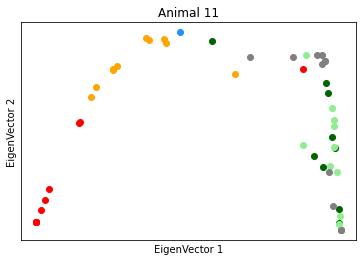

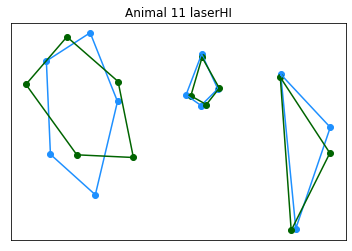

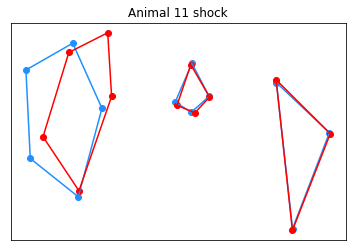

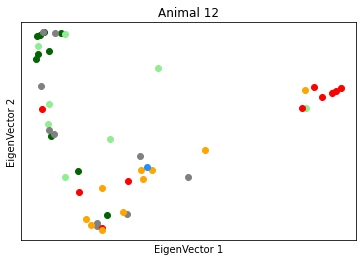

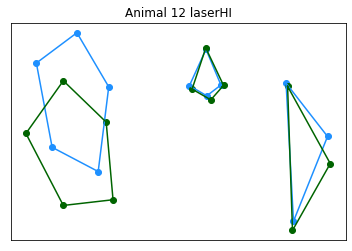

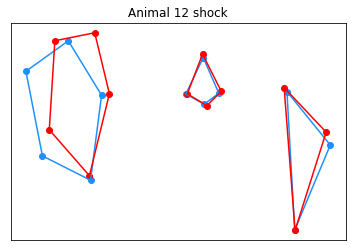

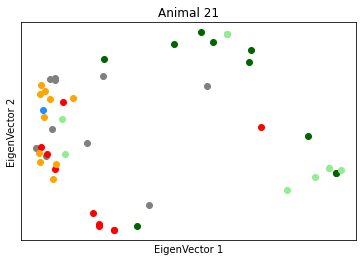

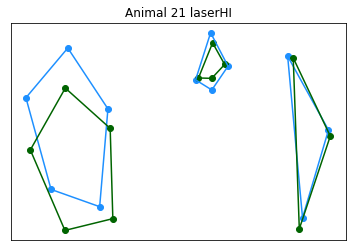

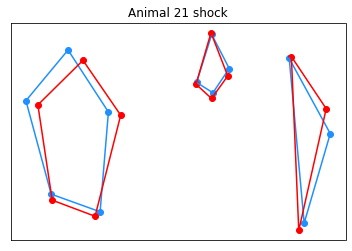

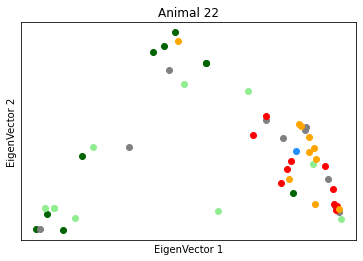

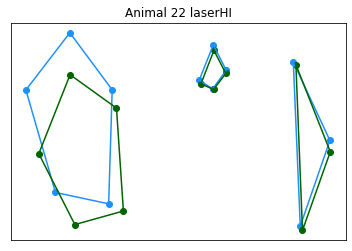

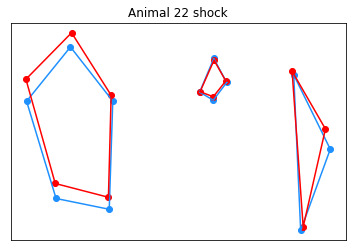

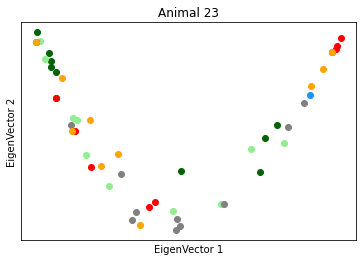

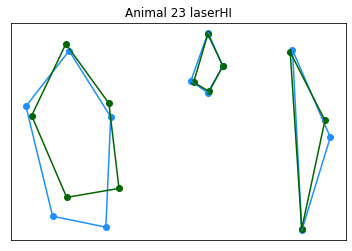

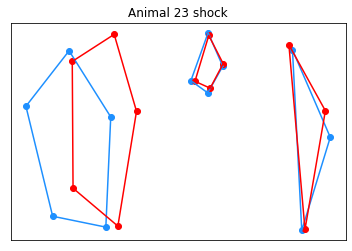

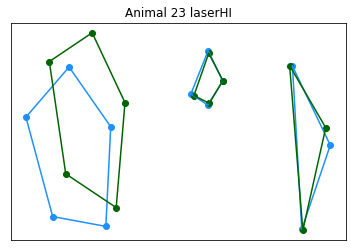

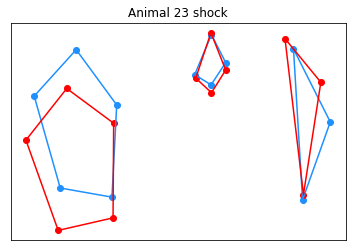

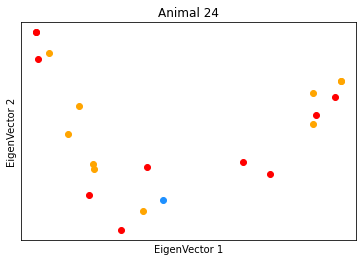

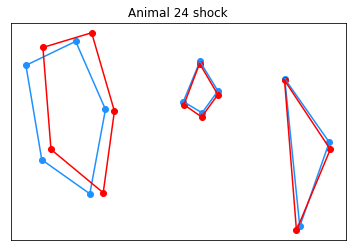

In [119]:
def classic_plot_2D(batch,animall,algorithm,typee,n,t):
    df = laplacian_2D(batch,animall,algorithm,typee,n,t)
    my_baseline = pd.read_csv("Batch" + str(batch) + "/BaselineExpression" + str(batch) + str(animall) + ".csv", index_col = 0)
    
    #print(df.sort_values(by = "x"))
    for ind in df.index:
        plt.scatter(df.at[ind,"x"],df.at[ind,"y"], c = colors.get(df.at[ind,"stimulus"]))
        #plt.text(df.at[ind,"x"]-0.01,df.at[ind,"y"], ind%10)
    #for ind in [0,10,20,30,40]:
    #    plt.scatter(df.at[ind,"x"],df.at[ind,"y"], c = colors.get(df.at[ind,"stimulus"]), label = df.at[ind,"stimulus"])
    plt.title("Animal " + str(batch) + str(animall)) #+ " " + algorithm) #+ " n = " + str(n))
    plt.xticks([],[])
    plt.yticks([],[])
    plt.xlabel("EigenVector 1")
    plt.ylabel("EigenVector 2")
    #plt.legend(bbox_to_anchor=(1, 1))
    #if(batch == "1" and animall == "1"):
    #    plt.savefig('presentation_Laplacian11.eps', format='eps')
    #if(batch == "2" and animall == "1"):
    #    plt.savefig('presentation_Laplacian21.eps', format='eps')
    plt.show()
    
    output = pd.read_csv("Batch" + str(batch) + "/OutputAnimal" + str(batch) + str(animall) + ".csv", index_col = 0)
    #plot(output,int(str(df.at[9,"image"])[:-2]),colors.get("laserHI"),"2")
    #plt.title("laserHI", size = 16)
    #plt.savefig('presentation_LEM_laserHIextreme21.eps', format='eps')
    #plt.show()
    
    #plot(output,int(str(df.at[0,"image"])[:-2]),colors.get("laserHI"),"2")
    #plt.title("laserHI", size = 16)
    #plt.savefig('presentation_LEM_laserHI21.eps', format='eps')
    #plt.show()
    
    #plot(output,int(str(df.at[23,"image"])[:-2]),colors.get("laserCTRL"),"2")
    #plt.title("laserCTRL", size = 16)
    #plt.savefig('presentation_LEM_laserCTRL21.eps', format='eps')
    #plt.show()
    
    #plot(output,int(str(df.at[49,"image"])[:-2]),colors.get("baseline"),"2")
    #plt.title("baseline", size = 16)
    #plt.savefig('presentation_LEM_baseline21.eps', format='eps')
    #plt.show()
    
    #plot(output,int(str(df.at[47,"image"])[:-2]),colors.get("shockCTRL"),"2")
    #plt.title("shockCTRL", size = 16)
    #plt.savefig('presentation_LEM_shockCTRL.eps', format='eps')
    #plt.show()

    #plot(output,int(str(df.at[38,"image"])[:-2]),colors.get("shock"),"2")
    #plt.title("shock", size = 16)
    #plt.savefig('presentation_LEM_shock21.eps', format='eps')
    #plt.show()
    
    #plot(output,int(str(df.at[39,"image"])[:-2]),colors.get("shock"),"2")
    #plt.title("shock", size = 16)
    #plt.savefig('presentation_LEM_painshock21.eps', format='eps')
    #plt.show()
    
    if((batch,animall) == ("1","1")):
        plot(my_baseline,0,"dodgerblue",batch)
        plt.title("Animal " + str(batch) + str(animall) + " laserHI")
        plot(output,int(str(df.at[6,"image"])[:-2]),colors.get("laserHI"),batch)
        plt.show()
        
        plot(my_baseline,0,"dodgerblue",batch)
        plt.title("Animal " + str(batch) + str(animall) + " shock")
        plot(output,int(str(df.at[37,"image"])[:-2]),colors.get("shock"),batch)
        plt.show()
    elif((batch,animall) == ("1","2")):
        plot(my_baseline,0,"dodgerblue",batch)
        plt.title("Animal " + str(batch) + str(animall) + " laserHI")
        plot(output,int(str(df.at[6,"image"])[:-2]),colors.get("laserHI"),batch)
        plt.show()
        
        plot(my_baseline,0,"dodgerblue",batch)
        plt.title("Animal " + str(batch) + str(animall) + " shock")
        plot(output,int(str(df.at[37,"image"])[:-2]),colors.get("shock"),batch)
        plt.show()
    elif((batch,animall) == ("2","1")):
        plot(my_baseline,0,"dodgerblue",batch)
        plot(output,int(str(df.at[9,"image"])[:-2]),colors.get("laserHI"),batch)
        plt.title("Animal " + str(batch) + str(animall) + " laserHI")
        plt.show()
        
        plot(my_baseline,0,"dodgerblue",batch)
        plot(output,int(str(df.at[31,"image"])[:-2]),colors.get("shock"),batch)
        plt.title("Animal " + str(batch) + str(animall) + " shock")
        plt.show()
    elif((batch,animall) == ("2","2")):
        plot(my_baseline,0,"dodgerblue",batch)
        plot(output,int(str(df.at[6,"image"])[:-2]),colors.get("laserHI"),batch)
        plt.title("Animal " + str(batch) + str(animall) + " laserHI")
        plt.show()
        
        plot(my_baseline,0,"dodgerblue",batch)
        plot(output,int(str(df.at[39,"image"])[:-2]),colors.get("shock"),batch)
        plt.title("Animal " + str(batch) + str(animall) + " shock")
        plt.show()
    elif((batch,animall) == ("2","3")):
        plot(my_baseline,0,"dodgerblue",batch)
        plot(output,int(str(df.at[9,"image"])[:-2]),colors.get("laserHI"),batch)
        plt.title("Animal " + str(batch) + str(animall) + " laserHI")
        plt.show()
        
        plot(my_baseline,0,"dodgerblue",batch)
        plot(output,int(str(df.at[32,"image"])[:-2]),colors.get("shock"),batch)
        plt.title("Animal " + str(batch) + str(animall) + " shock")
        plt.show()
        
        plot(my_baseline,0,"dodgerblue",batch)
        plot(output,int(str(df.at[0,"image"])[:-2]),colors.get("laserHI"),batch)
        plt.title("Animal " + str(batch) + str(animall) + " laserHI")
        plt.show()
        
        plot(my_baseline,0,"dodgerblue",batch)
        plot(output,int(str(df.at[30,"image"])[:-2]),colors.get("shock"),batch)
        plt.title("Animal " + str(batch) + str(animall) + " shock")
        plt.show()
    elif((batch,animall) == ("2","4")):
        plot(my_baseline,0,"dodgerblue",batch)
        plt.title("Animal " + str(batch) + str(animall) + " shock")
        plot(output,int(str(df.at[1,"image"])[:-2]),colors.get("shock"),batch)
        plt.show()
    
    
    

#Euclidian Kernel n=6, t = 640
#classic_plot_2D("1","1","Euclidian_Kernel","",6,640)  
#classic_plot_2D("1","2","Euclidian_Kernel","",6,640)  
#classic_plot_2D("2","1","Euclidian_Kernel","",6,640)  
#classic_plot_2D("2","2","Euclidian_Kernel","",6,640)  
#classic_plot_2D("2","3","Euclidian_Kernel","",6,640)  
#classic_plot_2D("2","4","Euclidian_Kernel","",6,640)  


classic_plot_2D("1","1","Euclidian_Simple","",6,0)  
classic_plot_2D("1","2","Euclidian_Simple","",6,0)  
classic_plot_2D("2","1","Euclidian_Simple","",6,0)  
classic_plot_2D("2","2","Euclidian_Simple","",6,0)  
classic_plot_2D("2","3","Euclidian_Simple","",6,0)  
classic_plot_2D("2","4","Euclidian_Simple","",6,0)  

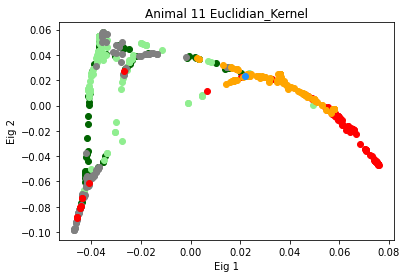

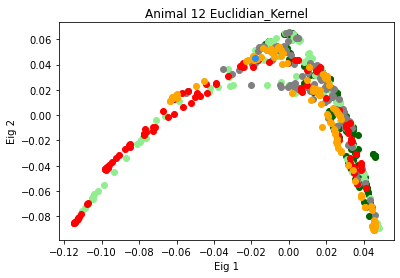

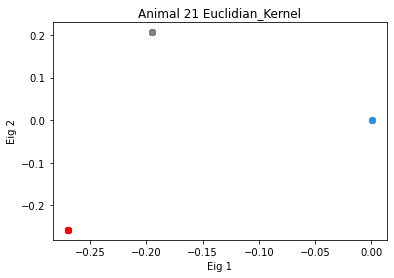

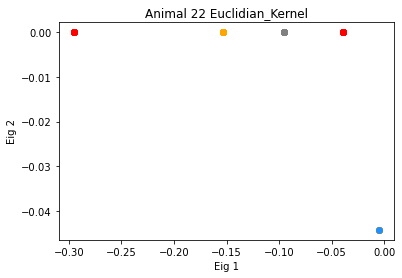

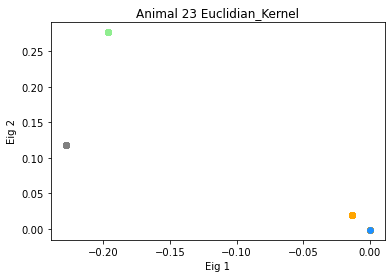

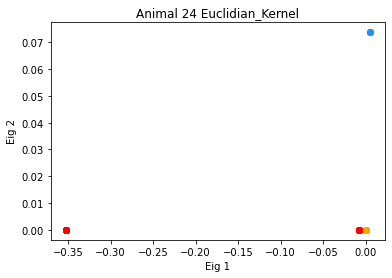

In [69]:
classic_plot_2D("1","1","Euclidian_Kernel","More_",6,640)  
classic_plot_2D("1","2","Euclidian_Kernel","More_",6,640)  
classic_plot_2D("2","1","Euclidian_Kernel","More_",6,640)  
classic_plot_2D("2","2","Euclidian_Kernel","More_",6,640)  
classic_plot_2D("2","3","Euclidian_Kernel","More_",6,640)  
classic_plot_2D("2","4","Euclidian_Kernel","More_",6,640)

In [91]:
print(list(colors.values()))

['dodgerblue', 'darkgreen', 'lightgreen', 'gray', 'red', 'orange', 'purple', 'pink']


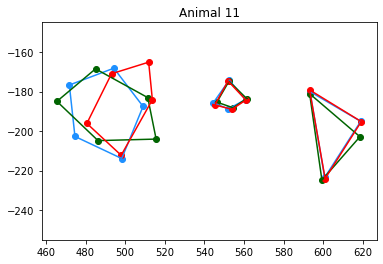

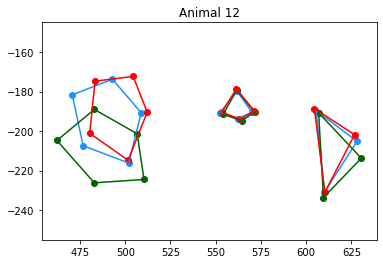

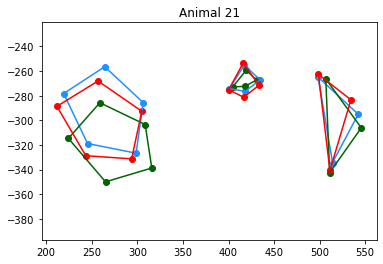

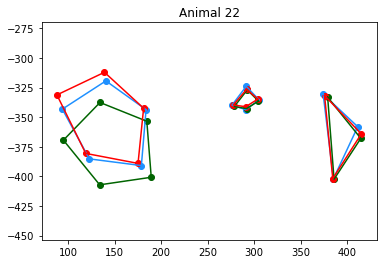

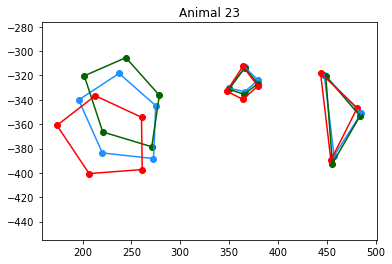

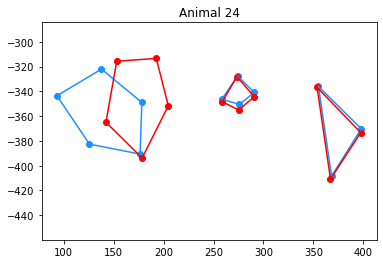

In [165]:
import plotly.express as px
def interactive_plot_2D(batch,animall,algorithm,typee,n,t):
    lap = laplacian_2D(batch,animall,algorithm,typee,n,t)
    max_expressions = pd.read_csv("Batch" + str(batch) + "/Frames_Maximal_Expressions_Animal" + str(batch) + str(animall) + ".csv", index_col = 0)
    my_baseline = pd.read_csv("Batch" + str(batch) + "/BaselineExpression" + str(batch) + str(animall) + ".csv", index_col = 0)
    df = pd.read_csv("Batch" + str(batch) + "/OutputAnimal" + str(batch) + str(animall) + ".csv", index_col = 0)
    if(batch == "2" and animall == "4"):
        fig = px.scatter(width = 650, height = 500, data_frame = lap, x='x', y='y', color = 'stimulus', color_discrete_sequence = ["red","orange","dodgerblue"], hover_data = {'x' : False, 'y': False, "z": False, 'trial': True, 'image' : True}, title = 'Data') #, size_max = 25, color = 'stimulus', colors.values, opacity = 0.6, )
    else:
        fig = px.scatter(width = 650, height = 500, data_frame = lap, x='x', y='y', color = 'stimulus', color_discrete_sequence = list(colors.values()), hover_data = {'x' : False, 'y': False, "z": False, 'trial': True, 'image' : True}, title = 'Data') #, size_max = 25, color = 'stimulus', colors.values, opacity = 0.6, )
    fig.show()
    
    if(batch == "1" and animall == "1"):
        plt.title("Animal " + str(batch) + str(animall))
        plot(my_baseline,0,colors.get("baseline"),1)
        plot(df,max_expressions.at[8,"laserHI"],colors.get("laserHI"),1)
        plot(df,max_expressions.at[7,"shock"],colors.get("shock"),1)
        plt.show()
    elif(batch == "1" and animall == "2"):
        plt.title("Animal " + str(batch) + str(animall))
        plot(my_baseline,0,colors.get("baseline"),1)
        plot(df,max_expressions.at[6,"laserHI"],colors.get("laserHI"),1)
        plot(df,max_expressions.at[7,"shock"],colors.get("shock"),1)
        plt.show()
    elif(batch == "2" and animall == "1"):
        plt.title("Animal " + str(batch) + str(animall))
        plot(my_baseline,0,colors.get("baseline"),1)
        plot(df,max_expressions.at[9,"laserHI"],colors.get("laserHI"),2)
        plot(df,max_expressions.at[1,"shock"],colors.get("shock"),2)
        plt.show()
    elif(batch == "2" and animall == "2"):
        plt.title("Animal " + str(batch) + str(animall))
        plot(my_baseline,0,colors.get("baseline"),1)
        plot(df,max_expressions.at[1,"laserHI"],colors.get("laserHI"),2)
        plot(df,max_expressions.at[9,"shock"],colors.get("shock"),2)
        plt.show()
    elif(batch == "2" and animall == "3"):
        plt.title("Animal " + str(batch) + str(animall))
        plot(my_baseline,0,colors.get("baseline"),1)
        plot(df,max_expressions.at[9,"laserHI"],colors.get("laserHI"),2)
        plot(df,max_expressions.at[0,"shock"],colors.get("shock"),2)
        plt.show()
    elif(batch == "2" and animall == "4"):
        plt.title("Animal " + str(batch) + str(animall))
        plot(my_baseline,0,colors.get("baseline"),1)
        plot(df,max_expressions.at[6,"shock"],colors.get("shock"),2)
        plt.show()


#Euclidian Kernel n=6, t = 640
#classic_plot_2D("1","1","Euclidian_Kernel","",6,640)  
#classic_plot_2D("1","2","Euclidian_Kernel","",6,640)  
#classic_plot_2D("2","1","Euclidian_Kernel","",6,640)  
#classic_plot_2D("2","2","Euclidian_Kernel","",6,640)  
#classic_plot_2D("2","3","Euclidian_Kernel","",6,640)  
#classic_plot_2D("2","4","Euclidian_Kernel","",6,640)  


interactive_plot_2D("1","1","Euclidian_Simple","",6,0)  
interactive_plot_2D("1","2","Euclidian_Simple","",6,0)  
interactive_plot_2D("2","1","Euclidian_Simple","",6,0)  
interactive_plot_2D("2","2","Euclidian_Simple","",6,0)  
interactive_plot_2D("2","3","Euclidian_Simple","",6,0)  
interactive_plot_2D("2","4","Euclidian_Simple","",6,0)  
#MAYBE SHOW - 

In [70]:
#only maximal expressions
df = pd.read_csv("Batch" + str("1") + "/OutputAnimal" + str("1") + str("1") + ".csv", index_col = 0)
data = pd.DataFrame(columns = df.columns)
data['stimulus'] = pd.Series(dtype = str)
data['stimulus_number'] = pd.Series(dtype = str)
data['frame'] = pd.Series(dtype = int)
data['animal'] = pd.Series(dtype = str)
z = 0
for (batch,animall) in [(1,1),(1,2),(2,1),(2,2),(2,3),(2,4)]:
    df = pd.read_csv("Batch" + str(batch) + "/OutputAnimal" + str(batch) + str(animall) + ".csv", index_col = 0)
    list_start = pd.read_csv("Batch" + str(batch) + "/list_start" + str(batch) + str(animall) + ".csv", index_col = 0)
    list_end = pd.read_csv("Batch" + str(batch) + "/list_end" + str(batch) + str(animall) + ".csv", index_col = 0)
    my_baseline = pd.read_csv("Batch" + str(batch) + "/BaselineExpression" + str(batch) + str(animall) + ".csv", index_col = 0)
    max_expressions = pd.read_csv("Batch" + str(batch) + "/Frames_Maximal_Expressions_Animal" + str(batch) + str(animall) + ".csv", index_col = 0)
    
    for y in max_expressions.columns:
        for x in range(0,10):
            data.at[z,'stimulus'] = str(y) 
            data.at[z,'stimulus_number'] = x
            data.at[z,'frame'] = int(max_expressions.at[x,y])
            data.at[z,'animal'] = str(batch) + str(animall)
            data.iloc[z, 0:24] = df.loc[max_expressions.at[x,y],:] - my_baseline.loc[0,:]
            z = z + 1  

print(data)
#data.to_csv("Data_Max_All_Animal_Laplacian.csv")
    
    
    

       Ear1.X    Ear1.Y   Ear2.X    Ear2.Y    Ear3.X   Ear3.Y    Ear4.X  \
0    0.669474   -4.8741 -7.56092 -0.392078  -7.37523  4.15284   8.51563   
1    0.651316   -1.5205 -6.64295   3.18187  -6.39714  7.57806   8.57602   
2    -1.78554  -2.02723 -5.48344  -1.42572   -4.4279  -0.3227 -0.389189   
3   -0.572042  -4.24683 -12.2953   3.07966  -12.2648   9.6209   10.6737   
4    -4.01931  -3.77864 -14.3912   3.39045  -15.4985  7.63899   3.40759   
..        ...       ...      ...       ...       ...      ...       ...   
265   8.92405   3.75965  10.2295    1.5717   6.28102  4.13261 -0.811169   
266  -5.56982 -0.738042 -12.5432   1.15199  -16.2722  2.59944  -12.2196   
267   2.53585  -1.50267  1.27382  -5.10683   3.20465 -2.39965   8.86968   
268 -0.996305 -0.167526 -0.29723  -3.78396  0.918844 -7.29405   -3.6248   
269   6.28657   1.66825  11.3006  -2.76145    11.506 -6.51466   2.71402   

      Ear4.Y     Ear5.X   Ear5.Y  ... SnoutMid.X SnoutMid.Y NoseTip.X  \
0    1.00961    14.4409 -8

In [2]:
def laplacian_2D_all_animals(algorithm,typee,n,t):
    df = pd.read_csv("Data_Max_All_Animal_Laplacian.csv", index_col = 0)
    
    #covariance matrix for Mahalanobis distance - need to do it for dataframe with all animals normalized
    #copy_df = pd.DataFrame.copy(df, deep = True)
    #copy_df = copy_df.dropna()
    #cov = np.cov(copy_df.values.T)
    #inv_cov = np.linalg.inv(cov)
    
    colors = {'laserHI': 'darkgreen', 'laserLO': 'lightgreen', 'laserCTRL': 'gray','shock':'red', 'shockCTRL': 'orange',
         'baseline': 'dodgerblue','squeak' : 'purple', 'squeakCTRL': 'pink', 'early_shock' :'darkred'} 
    
    dataframe = pd.read_csv("Data_Max_All_Animal_Laplacian.csv", index_col = 0)
    dataframe1 = dataframe.drop(columns = ['stimulus','stimulus_number','frame','animal'])
    
    #fixing missing values
    for ind in dataframe.index:
        if(str(dataframe.iat[ind,0]) == 'nan' or dataframe.iat[ind,0] == np.nan):
            dataframe.iloc[ind,0:24] = dataframe.iloc[ind-1,0:24]
            dataframe1.iloc[ind,0:24] = dataframe1.iloc[ind-1,0:24]
    
    if algorithm == 'Mahalanobis_Kernel':
        A_neigh = kneighbors_graph(dataframe1, n_neighbors=n, metric = 'mahalanobis', metric_params={'V': cov}).toarray()
        A_neigh = 0.5 * (A_neigh + A_neigh.T)  # enforce symmetry
    
        W_neigh = np.zeros(shape=(len(dataframe1.index),len(dataframe1.index)))
        for i in range(0,len(dataframe1.index)):
            for j in range(0,len(dataframe1.index)):
                if(A_neigh[i,j] > 0):
                    dist = distance.mahalanobis(dataframe1.loc[i,:], dataframe1.loc[j,:], inv_cov)**2
                    W_neigh[i,j] = math.exp(-dist/t)
    elif algorithm == 'Euclidian_Kernel':
        A_neigh = kneighbors_graph(dataframe1, n_neighbors=n).toarray()
        A_neigh = 0.5 * (A_neigh + A_neigh.T)  # enforce symmetry
    
        def heat_kernel(x, y, t):
            dist_2 = np.linalg.norm(x - y)**2
            w = np.exp(-dist_2/t)
            return w
    
        W_neigh = np.zeros(shape=(len(dataframe1.index),len(dataframe1.index)))
        for i in range(0,len(dataframe1.index)):
            for j in range(0,len(dataframe1.index)):
                if(A_neigh[i,j] > 0):
                    W_neigh[i,j] = heat_kernel(dataframe1.loc[i,:].to_numpy(),dataframe1.loc[j,:].to_numpy(),t)
    elif algorithm == "Mahalanobis_Simple":
        A_neigh = kneighbors_graph(dataframe1, n_neighbors=n, metric = 'mahalanobis', metric_params={'V': cov}).toarray()
        A_neigh = 0.5 * (A_neigh + A_neigh.T)  # enforce symmetry
    
        W_neigh = np.zeros(shape=(len(dataframe1.index),len(dataframe1.index)))
        for i in range(0,len(dataframe1.index)):
            for j in range(0,len(dataframe1.index)):
                if(A_neigh[i,j] > 0):
                    W_neigh[i,j] = 1
    elif algorithm == "Euclidian_Simple":
        A_neigh = kneighbors_graph(dataframe1, n_neighbors=n).toarray()
        A_neigh = 0.5 * (A_neigh + A_neigh.T)  # enforce symmetry
    
        W_neigh = np.zeros(shape=(len(dataframe1.index),len(dataframe1.index)))
        for i in range(0,len(dataframe1.index)):
            for j in range(0,len(dataframe1.index)):
                if(A_neigh[i,j] > 0):
                    W_neigh[i,j] = 1
                    
    D_neigh = np.diag(np.apply_along_axis(arr=W_neigh,
                                func1d=np.sum,
                                axis=0))
    
    L_neigh = D_neigh - W_neigh
    LL_neigh = np.dot(np.linalg.inv(D_neigh),L_neigh)
    
    eigenValues_neigh, eigenVectors_neigh = la.eig(LL_neigh)
    idx = eigenValues_neigh.argsort()   
    eigenValues_neigh = eigenValues_neigh[idx]
    eigenVectors_neigh = eigenVectors_neigh[:,idx]
    vector_1_neigh = eigenVectors_neigh[:,1]
    vector_2_neigh = eigenVectors_neigh[:,2]
    vector_3_neigh = eigenVectors_neigh[:,3]
    
    data_eig = pd.DataFrame(index = dataframe.index, columns = ['x','y','z','stimulus','trial','image','animal'])
    data_eig['x'] = pd.Series(vector_1_neigh)
    data_eig['y'] = pd.Series(vector_2_neigh)
    data_eig['z'] = pd.Series(vector_3_neigh)
    data_eig['stimulus'] = pd.Series(dataframe['stimulus'])
    data_eig['image'] = pd.Series(dataframe['frame'])
    data_eig['trial'] = pd.Series(dataframe['stimulus_number'])
    data_eig['animal'] = pd.Series(dataframe['animal'])
    #reating DataFrame with 4 variables to export for image-hovering in R
    #for ind in dataFrameToSave.index:
    #    #plot(df, data_eig.at[ind,'frame'], colors.get(data_eig.at[ind,'stimulus']))
    #    #plt.savefig("ForRStudio/all_images_Animal" + str(animal) +""/" + str(data_eig.at[ind,'frame']) + ".png")
    #    dataFrameToSave.at[ind,'image'] = str(data_eig.at[ind,'frame']) + ".png"
    #    #plt.show()
    return(data_eig)
    

    
    
    
laplacian_2D_all_animals("Euclidian_Simple","",6,20)   

x         y         z   stimulus  trial    image  animal
0    0.159840 -0.125652 -0.043459    laserHI      0   7488.0      11
1    0.163584 -0.132415 -0.046572    laserHI      1   8034.0      11
2    0.034589  0.027220  0.034823    laserHI      2   9106.0      11
3    0.163066 -0.114194 -0.037062    laserHI      3   9983.0      11
4    0.124319 -0.053769 -0.009895    laserHI      4  10735.0      11
..        ...       ...       ...        ...    ...      ...     ...
265 -0.008546  0.016899  0.039549  shockCTRL      5   8481.0      24
266  0.047426  0.043928  0.049169  shockCTRL      6   8979.0      24
267  0.008058 -0.003982 -0.010914  shockCTRL      7   9559.0      24
268 -0.007118  0.010293  0.056834  shockCTRL      8  10165.0      24
269 -0.043695 -0.031227  0.039418  shockCTRL      9  10573.0      24

[270 rows x 7 columns]

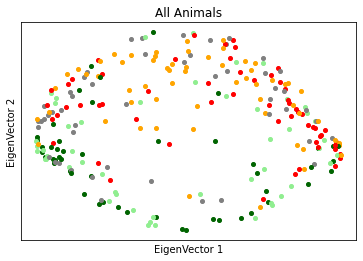

In [3]:
def classic_plot_2D_all_animals(algorithm,typee,n,t):
    df = laplacian_2D_all_animals(algorithm,typee,n,t)
    #my_baseline = pd.read_csv("Batch" + str(batch) + "/BaselineExpression" + str(batch) + str(animall) + ".csv", index_col = 0)
    
    #print(df.sort_values(by = "x"))
    for ind in df.index:
        plt.scatter(df.at[ind,"x"],df.at[ind,"y"], c = colors.get(df.at[ind,"stimulus"]), s = 16)
    #for ind in [0,10,20,30,40]:
    #    plt.scatter(df.at[ind,"x"],df.at[ind,"y"], c = colors.get(df.at[ind,"stimulus"]), label = df.at[ind,"stimulus"])
    plt.title("All Animals") #+ " " + algorithm) #+ " n = " + str(n))
    plt.xticks([],[])
    plt.yticks([],[])
    plt.xlabel("EigenVector 1")
    plt.ylabel("EigenVector 2")
    #plt.legend(bbox_to_anchor=(1, 1))
    #if(batch == "1" and animall == "1"):
    #    plt.savefig('presentation_Laplacian11.eps', format='eps')
    #if(batch == "2" and animall == "1"):
    #    plt.savefig('presentation_Laplacian21.eps', format='eps')
    plt.savefig('presentation_LaplacianAllAnimals.eps', format='eps')
    plt.show()
    
    #Plotting 3D
    #col_seq = []
    #for ind in df.index:
    #    col_seq.append(colors.get(df.at[ind,"stimulus"]))
    #fig = plt.figure()
    #ax = fig.add_subplot(111, projection='3d')
    #ax.scatter(df["x"],df["y"],df["z"], c = col_seq)
    #plt.show()
    
    
classic_plot_2D_all_animals("Euclidian_Simple","",36,0)

In [12]:
import plotly.express as px
def interactive_plot_2D_all_animals(algorithm,typee,n,t):
    df = laplacian_2D_all_animals(algorithm,typee,n,t)
    #my_baseline = pd.read_csv("Batch" + str(batch) + "/BaselineExpression" + str(batch) + str(animall) + ".csv", index_col = 0)
    
    import plotly.express as px
    fig = px.scatter(width = 800, height = 600, data_frame = df, x='x', y='y', size_max = 20, color = 'stimulus', color_discrete_sequence = [colors[k] for k in colors], hover_data = {'x' : False, 'y': False, 'stimulus' : False, 'trial': True, 'animal' : True})#, opacity = 0.6) #olor = 'stimulus', color_discrete_sequence = colors, opacity = 0.6, hover_data = {'x' : False, 'y': False, "z": False, 'trial': True, 'animal' : True}, title = 'Data = Max Expressions')
    fig.show()
    
interactive_plot_2D_all_animals("Euclidian_Simple","",36,0)

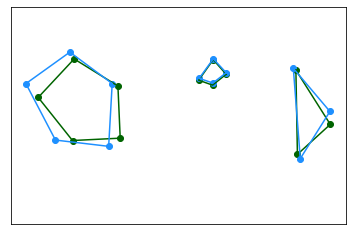

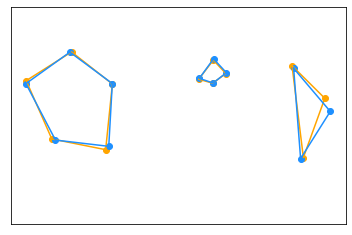

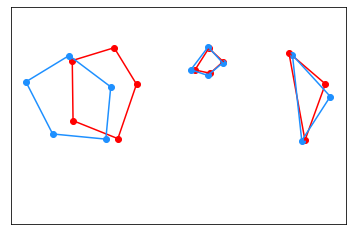

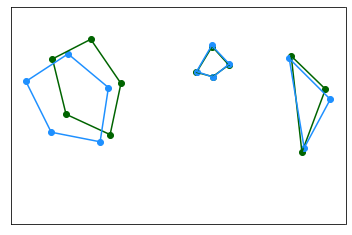

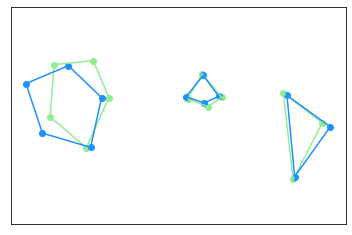

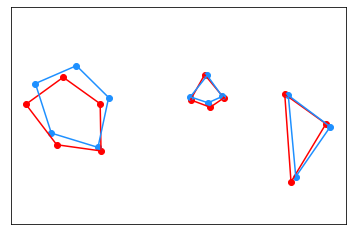

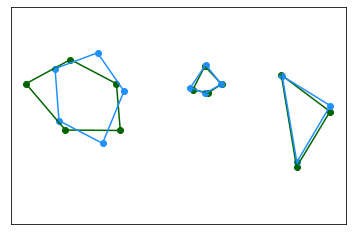

In [10]:
def plot_max_facial(batch,animall,trial,stimulus):
    df = pd.read_csv("Batch" + str(batch) + "/OutputAnimal" + str(batch) + str(animall) + ".csv", index_col = 0)
    list_start = pd.read_csv("Batch" + str(batch) + "/list_start" + str(batch) + str(animall) + ".csv", index_col = 0)
    list_end = pd.read_csv("Batch" + str(batch) + "/list_end" + str(batch) + str(animall) + ".csv", index_col = 0)
    my_baseline = pd.read_csv("Batch" + str(batch) + "/BaselineExpression" + str(batch) + str(animall) + ".csv", index_col = 0)
    max_expressions = pd.read_csv("Batch" + str(batch) + "/Frames_Maximal_Expressions_Animal" + str(batch) + str(animall) + ".csv", index_col = 0)
    
    plot(df,max_expressions.at[trial,stimulus],colors.get(stimulus),batch)
    plot(my_baseline,0,"dodgerblue",batch)
    plt.savefig('presentation_expression' + batch + animall + '_' + stimulus + str(trial) + '.eps', format='eps')
    plt.show()
    

plot_max_facial("2","2",7,"laserHI")
plot_max_facial("2","2",8,"shockCTRL")

#right area
plot_max_facial("2","3",2,"shock")
plot_max_facial("2","1",1,"laserHI")
plot_max_facial("1","2",9,"laserLO")

#left area
plot_max_facial("1","2",0,"shock")
plot_max_facial("1","1",4,"laserHI")


In [5]:
import plotly.express as px
def classic_plot_3D_all_animals(algorithm,typee,n,t):
    df = laplacian_2D_all_animals(algorithm,typee,n,t)
    #my_baseline = pd.read_csv("Batch" + str(batch) + "/BaselineExpression" + str(batch) + str(animall) + ".csv", index_col = 0)
    
    import plotly.express as px
    fig = px.scatter_3d(width = 1100, height = 800, data_frame = df, x='x', y='y', z='z', size_max = 20, color = 'stimulus', color_discrete_sequence = [colors[k] for k in colors])#, opacity = 0.6) #olor = 'stimulus', color_discrete_sequence = colors, opacity = 0.6, hover_data = {'x' : False, 'y': False, "z": False, 'trial': True, 'animal' : True}, title = 'Data = Max Expressions')
    fig.show()
    
classic_plot_3D_all_animals("Euclidian_Simple","",36,0)